In [42]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from sklearn.metrics import f1_score

In [43]:
dataset = np.load("dataset.npz")
X, y = dataset["X"], dataset["y"]
print(X[0])

[ 67  61  49  48  43   7   1  76   8  54  75  83  32  21  33  80  55  46
  67  51  41  81  11  35  29  62  73  32  19  76   1  24  76  86  74  75
  76  50  58  84  69  50  18  11  52  76  75  28  17  57  76  39   6   9
  67  43  78  76  18  46  31  10  41  75  36  64  10   6  77 194 229 150
  33   4  55  86  25  12  46  67  80  58   2  88  24  64   1  61 170 241
 251 180  47  35  67  58  27  36  85  53   2  30  37  60  73  44   5 121
 227 254 253 202  84   5  76  57  71  50  86  54  45   0  20  81  74   2
  23 173 246 255 254 242 167  22   2  24  30  58  86  28  83  38  36  21
   1  30 122 227 253 249 246 251 219  81  13  44  76  47  17  16  15  30
  85  76   8  95 219 251 245 208 200 243 243 164  45   1  25  67  43  73
  39  29  42   2  35 178 248 253 211 110 125 220 251 229 106  10  87  66
   9  37  69   8  56   7  68 218 254 251 189  84  97 200 252 250 173  51
   7  40  38   3  47  73  13  20 115 238 255 249 203 169 184 223 252 254
 237 137  36   2  29  57  66  61   6  79 197 250 25

In [44]:
print(X[5].reshape(20,20))
print(y[5])

[[ 74  15  22  87  29  73  25  57  79  73  61  43   8  74  40  41  34  21
   58  31]
 [ 21  82  82  51  49  29  50  31   9   9   2   7   3  71  87  24  48  71
   18  64]
 [ 69  24  54  43  59  35  47  16  14  62 104 142  95  28   3   7   3  76
   45  22]
 [ 59  52  32  15  21  27  60   3  55 198 244 252 236 160  48   4  27  37
   25  23]
 [ 21   1  80  81  55  10  53  97 128 213 238 226 239 242 132  29  84  48
   25  32]
 [ 12  55  62  59   4  62 195 236 235 188 122  78 157 248 189  70   1  20
   42  38]
 [ 11  45  14  51   6  87 237 252 237 158  50  15 138 248 196  76   1  50
   23  84]
 [  2   6  55  73   3  57 200 243 156  63  45 111 222 247 153  38  70  72
    1  20]
 [  5  17  79  62  10   9 100 224 192 114 158 231 243 177  69  12  10  83
   50  10]
 [ 23  69  69  27  78   1  27 169 243 233 245 245 168  46   5  31  43  55
   27   0]
 [  5   6  60  28   1  16  87 211 254 254 251 196  55   3   7  22  50  64
   81  65]
 [ 20  32  40  16  13  89 214 250 247 238 242 204  67   3  89  22

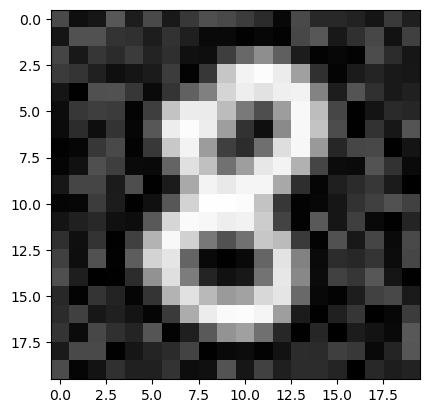

In [45]:
plt.imshow(X[5].reshape(20,20), vmin=0, vmax=255, cmap="gray")
plt.show()

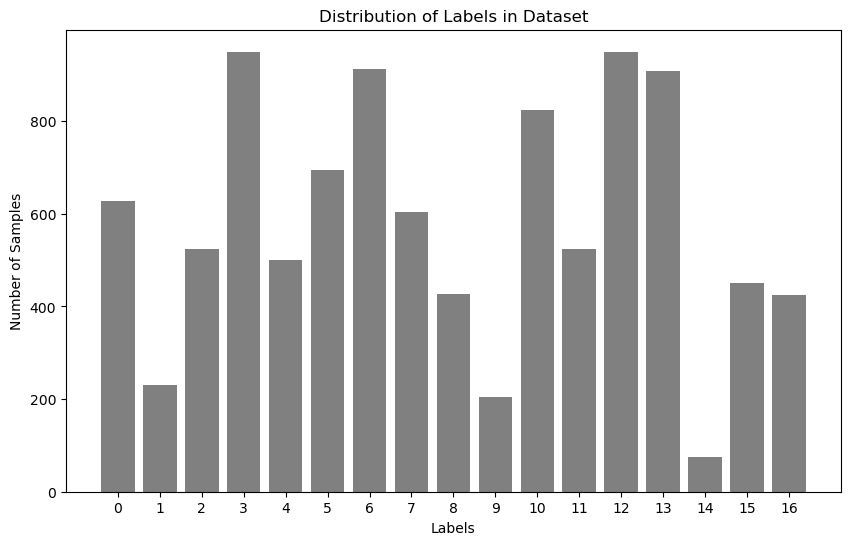

950
74


In [46]:
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter

# Load your dataset
dataset = np.load("dataset.npz")
X, y = dataset["X"], dataset["y"]

# Count the number of instances for each label
label_counts = Counter(y)

# Extract labels and their corresponding counts
labels = list(label_counts.keys())
counts = list(label_counts.values())

# Sort the labels and counts for better visualization
sorted_labels_counts = sorted(zip(labels, counts), key=lambda x: x[0])
sorted_labels, sorted_counts = zip(*sorted_labels_counts)


plt.figure(figsize=(10, 6))
plt.bar(sorted_labels, sorted_counts, color='gray')
plt.xlabel('Labels')
plt.ylabel('Number of Samples')
plt.title('Distribution of Labels in Dataset')
plt.xticks(sorted_labels)  
plt.show()

print(max(label_counts.values()))
print(min(label_counts.values()))


My approach

Data Preprocessing:

Normalize the pixel values.
Use SMOTE to handle the imbalanced dataset if needed.
Optionally use PCA to reduce the dimensionality and denoise the data.
Classifier Training:

Start with SVM or Random Forest using class_weight='balanced'.
If needed, apply oversampling (SMOTE) and retrain with reduced class weights.
Evaluation:

Focus on metrics like Precision, Recall, F1-score, and AUC-ROC for better evaluation of minority class performance.
Plot the confusion matrix to understand specific misclassifications.
Consider CNNs (Optional):

If accuracy is crucial and computation resources are available, using CNN would likely yield the best results, especially for handwritten digit recognition tasks.

In [47]:
# Set seed 
seed = 0
np.random.seed(seed)

# kfold if i want to use it
kf = KFold(n_splits=5, shuffle=True, random_state=seed)

In [48]:
# Function for tuning random forest using k-fold cross validation

def tune_random_forest(model_type, X_train_val, y_train_val, n_estimators, max_depth_params, criterion, max_features, kf):
    best_accuracy = [0]  # To store the best average accuracy and the hyperparameters
    
    # Iterate through all combinations of hyperparameters
    for maxdp in max_depth_params:
        for n_est in n_estimators:
            for crit in criterion:
                for mf in max_features:
                    
                    if model_type == "SklearnRandomForest":
                        rf = RandomForestClassifier(n_estimators=n_est, max_depth=maxdp, criterion=crit, max_features=mf , random_state=seed, class_weight="balanced")
                    else:
                        raise ValueError("Invalid model_type. Choose either 'RandomForest' or 'SklearnRandomForest'.")
                    
                    # List to store accuracies for each fold in the k-fold cross validation
                    fold_accuracies = []
                    
                    # k-fold cross-validation
                    for train_index, val_index in kf.split(X_train_val):
                        # Split the data into training and validation sets for each fold
                        X_training, X_val = X_train_val[train_index], X_train_val[val_index]
                        y_training, y_val = y_train_val[train_index], y_train_val[val_index]
                        
                        # Fit random forest on the training data
                        rf.fit(X_training, y_training)
                        
                        # Predict validation
                        y_pred = rf.predict(X_val)

        
                        
                        # Calculate accuracy for the current fold
                        # accuracy = accuracy_score(y_val, y_pred)
                        accuracy = f1_score(y_val, y_pred, average='weighted')
                        fold_accuracies.append(accuracy)
                    
                    # Calculate average accuracy across all folds
                    average_accuracy = np.mean(fold_accuracies)
                    
                    # If current average is better then update the best average accuracy
                    if average_accuracy > best_accuracy[0]:
                        best_accuracy = [average_accuracy, n_est, maxdp, crit, mf]
    
    # Return the best hyperparameters and accuracy
    return best_accuracy

In [49]:



#Split the data into test and (training and validation)
X_train_val, X_test, y_train_val, y_test = train_test_split(X,y, test_size=0.3, random_state=seed, shuffle=True)

# Normalize the data
# Normalize the data to [0, 1] range (assuming pixel values range from 0 to 255)
X_train_val = X_train_val / 255.0
X_test = X_test / 255.0

rf = RandomForestClassifier()

# Lists of hyperparameters that i want to tune
max_depth_params = [15,20]

n_estimators = [10,15]

criterion = ["gini", "entropy"]

max_features = ["sqrt"]



In [50]:
# Find best values for hyperparameters for sklearn random forest classifier
best_hypermeters_random_forest_sklearn = tune_random_forest("SklearnRandomForest",X_train_val, y_train_val, n_estimators, max_depth_params, criterion, max_features, kf)

print(best_hypermeters_random_forest_sklearn)

print(f"The best average accuracy is {best_hypermeters_random_forest_sklearn[0]} with N_estimators: {best_hypermeters_random_forest_sklearn [1]}, Max_depth: {best_hypermeters_random_forest_sklearn [2]}, Criterion: {best_hypermeters_random_forest_sklearn [3]}, Max_features: {best_hypermeters_random_forest_sklearn [4]}.\n")



[np.float64(0.7953255854140368), 15, 15, 'entropy', 'sqrt']
The best average accuracy is 0.7953255854140368 with N_estimators: 15, Max_depth: 15, Criterion: entropy, Max_features: sqrt.



In [58]:
# Testing the hyperparameters on test set

rf = RandomForestClassifier(n_estimators=best_hypermeters_random_forest_sklearn[1], max_depth=best_hypermeters_random_forest_sklearn[2], criterion=best_hypermeters_random_forest_sklearn[3], max_features=best_hypermeters_random_forest_sklearn[4], random_state=seed, class_weight="balanced")

rf.fit(X_train_val,y_train_val)

print(f"Training and validation accuracy: {accuracy_score(y_train_val, rf.predict(X_train_val))}")
print(f"Test accuracy: {accuracy_score(y_test, rf.predict(X_test))}")

print(f1_score(y_test, rf.predict(X_test), average='weighted'))

macro_f1 = f1_score(y_test, rf.predict(X_test), average='macro')
micro_f1 = f1_score(y_test, rf.predict(X_test), average='micro')

print(f"Macro F1-score: {macro_f1}")
print(f"Micro F1-score: {micro_f1}")

Training and validation accuracy: 0.99970942902804
Test accuracy: 0.7912572009488309
0.784157965332514
Macro F1-score: 0.740517788173791
Micro F1-score: 0.7912572009488309


In [59]:
from collections import Counter

print("Training class distribution:", Counter(y_train_val))
print("Test class distribution:", Counter(y_test))


Training class distribution: Counter({np.uint8(6): 664, np.uint8(3): 658, np.uint8(12): 647, np.uint8(13): 637, np.uint8(10): 583, np.uint8(5): 488, np.uint8(0): 443, np.uint8(7): 410, np.uint8(2): 374, np.uint8(4): 358, np.uint8(11): 351, np.uint8(16): 312, np.uint8(15): 310, np.uint8(8): 298, np.uint8(1): 153, np.uint8(9): 145, np.uint8(14): 52})
Test class distribution: Counter({np.uint8(12): 303, np.uint8(3): 292, np.uint8(13): 272, np.uint8(6): 248, np.uint8(10): 242, np.uint8(5): 207, np.uint8(7): 195, np.uint8(0): 184, np.uint8(11): 174, np.uint8(2): 151, np.uint8(4): 142, np.uint8(15): 140, np.uint8(8): 129, np.uint8(16): 113, np.uint8(1): 77, np.uint8(9): 60, np.uint8(14): 22})


In [60]:
from sklearn.metrics import classification_report

print(classification_report(y_test, rf.predict(X_test)))

              precision    recall  f1-score   support

           0       0.73      0.78      0.76       184
           1       0.82      0.95      0.88        77
           2       0.83      0.68      0.74       151
           3       0.79      0.89      0.84       292
           4       0.69      0.82      0.75       142
           5       0.76      0.77      0.77       207
           6       0.79      0.87      0.83       248
           7       0.80      0.90      0.85       195
           8       0.74      0.60      0.67       129
           9       0.73      0.37      0.49        60
          10       0.78      0.90      0.83       242
          11       0.79      0.53      0.64       174
          12       0.88      0.93      0.90       303
          13       0.75      0.72      0.73       272
          14       0.75      0.14      0.23        22
          15       0.77      0.63      0.69       140
          16       1.00      1.00      1.00       113

    accuracy              